In [1]:

input_dim = 4
num_clusters = 3
num_classes = 3

ntrials = 10
lg = 2.0 #lambda_global

model_file = "/home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"

import csv
import json
import numpy as np
import os
import pandas as pd


import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from load_scvis import load_vae
from metrics import metrics, eval_epsilon
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation, plot_similarity
from misc import poly2labels

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# Load Data & Configuration

x = pd.read_csv("Data/X.tsv", sep="\t").values

y = pd.read_csv("Data/y.tsv", sep="\t").values


with open("vertices.json") as json_file:  
    all_vertices = json.load(json_file)


[Text(133.92000000000002, 181.2, 'X[3] <= 0.292\ngini = 0.667\nsamples = 149\nvalue = [49, 50, 50]'),
 Text(66.96000000000001, 108.72, 'gini = 0.0\nsamples = 49\nvalue = [49, 0, 0]'),
 Text(200.88000000000002, 108.72, 'X[3] <= 0.688\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(133.92000000000002, 36.23999999999998, 'gini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(267.84000000000003, 36.23999999999998, 'gini = 0.043\nsamples = 46\nvalue = [0, 1, 45]')]

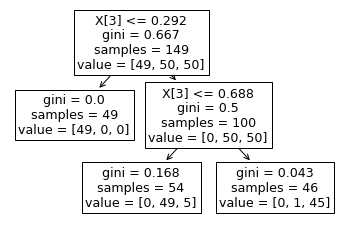

In [3]:
# Find a simple Decision Tree for this dataset

from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth = 2)

clf = clf.fit(x, y)
tree.plot_tree(clf)  


In [4]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


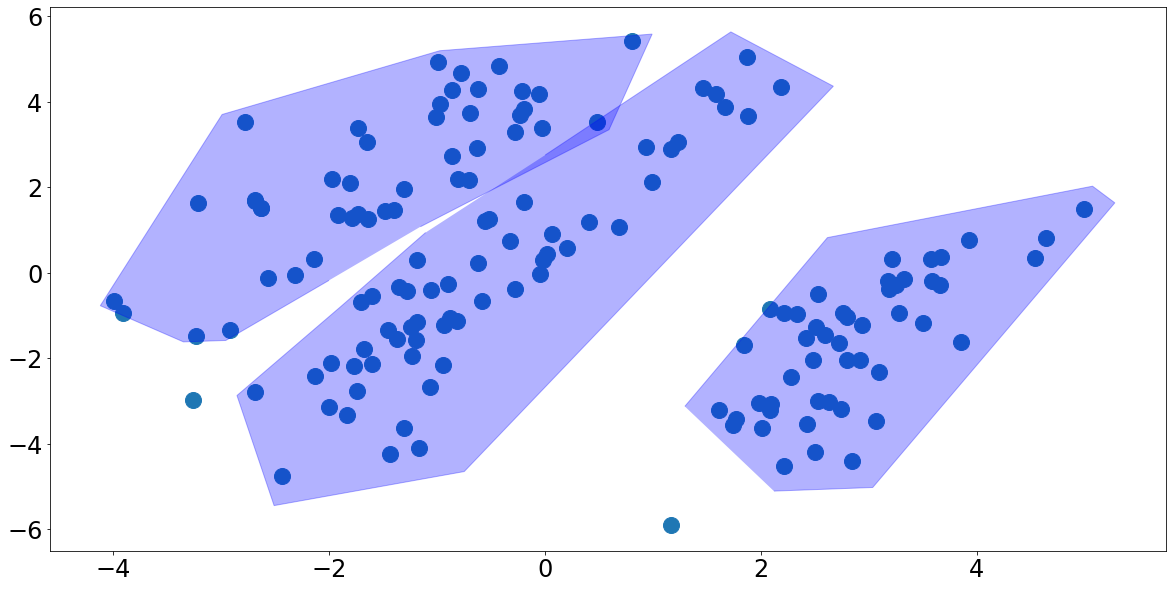

In [5]:
# Visualize the data and the marked clusters

plot_polys(data_rep, all_vertices)

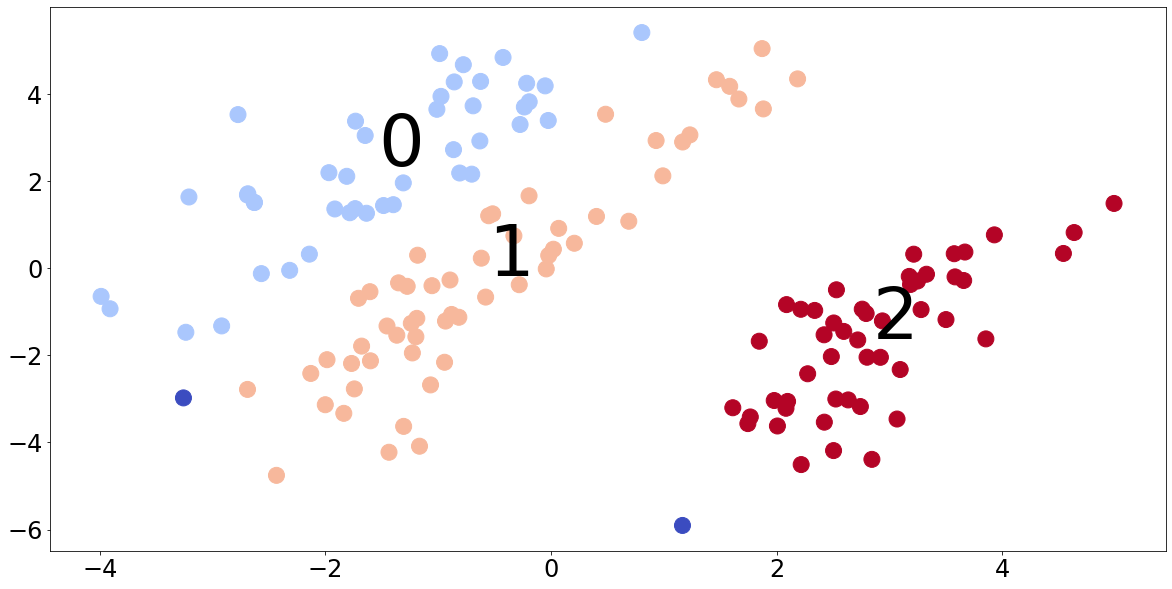

In [6]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "iris-rep.png")


In [7]:
# Inspect the correlation between cluster and class

confusion  = np.zeros((num_clusters, num_classes))
for i in range(y.shape[0]):
    if labels[i] != -1.0:
        confusion[int(labels[i]), int(y[i])] += 1
    
print(confusion)

[[ 0.  5. 38.]
 [ 0. 44. 12.]
 [48.  0.  0.]]


In [8]:
# Set epsilon for our metrics

epsilon = 0.75

if True:
    eval_epsilon(load_model, x, indices, epsilon)


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


In [9]:
# Compute the group explanations

best_val = 0.0
for i in range(ntrials):
    deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = lg)
    a, b = metrics(load_model, x, indices, deltas, epsilon)
    
    val = np.mean(a)
    
    if val > best_val:
        best_val = val
        np.save("deltas.npy", deltas)
    
    os.system("rm -rf explanation")

                    

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt



INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimens

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


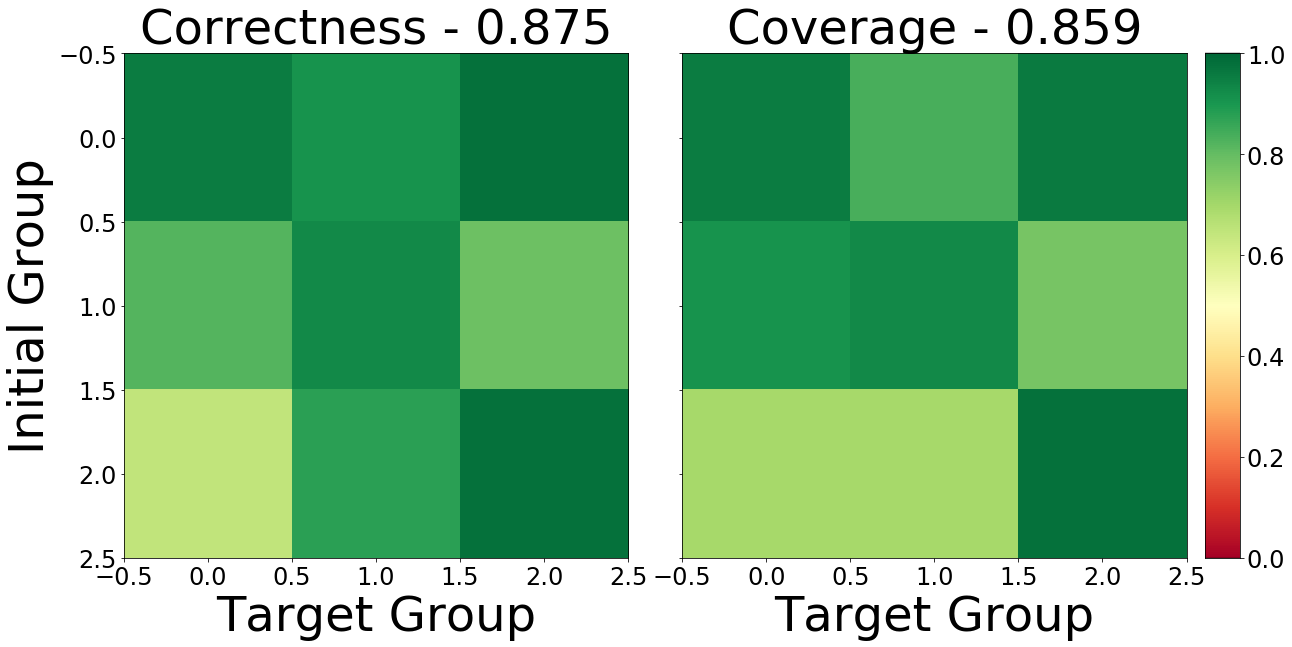

In [10]:
# Evaluate the explanations

deltas = np.load("deltas.npy")

a, b = metrics(load_model, x, indices, deltas, epsilon)

plot_metrics(a, b, name = "iris-metrics.png")


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


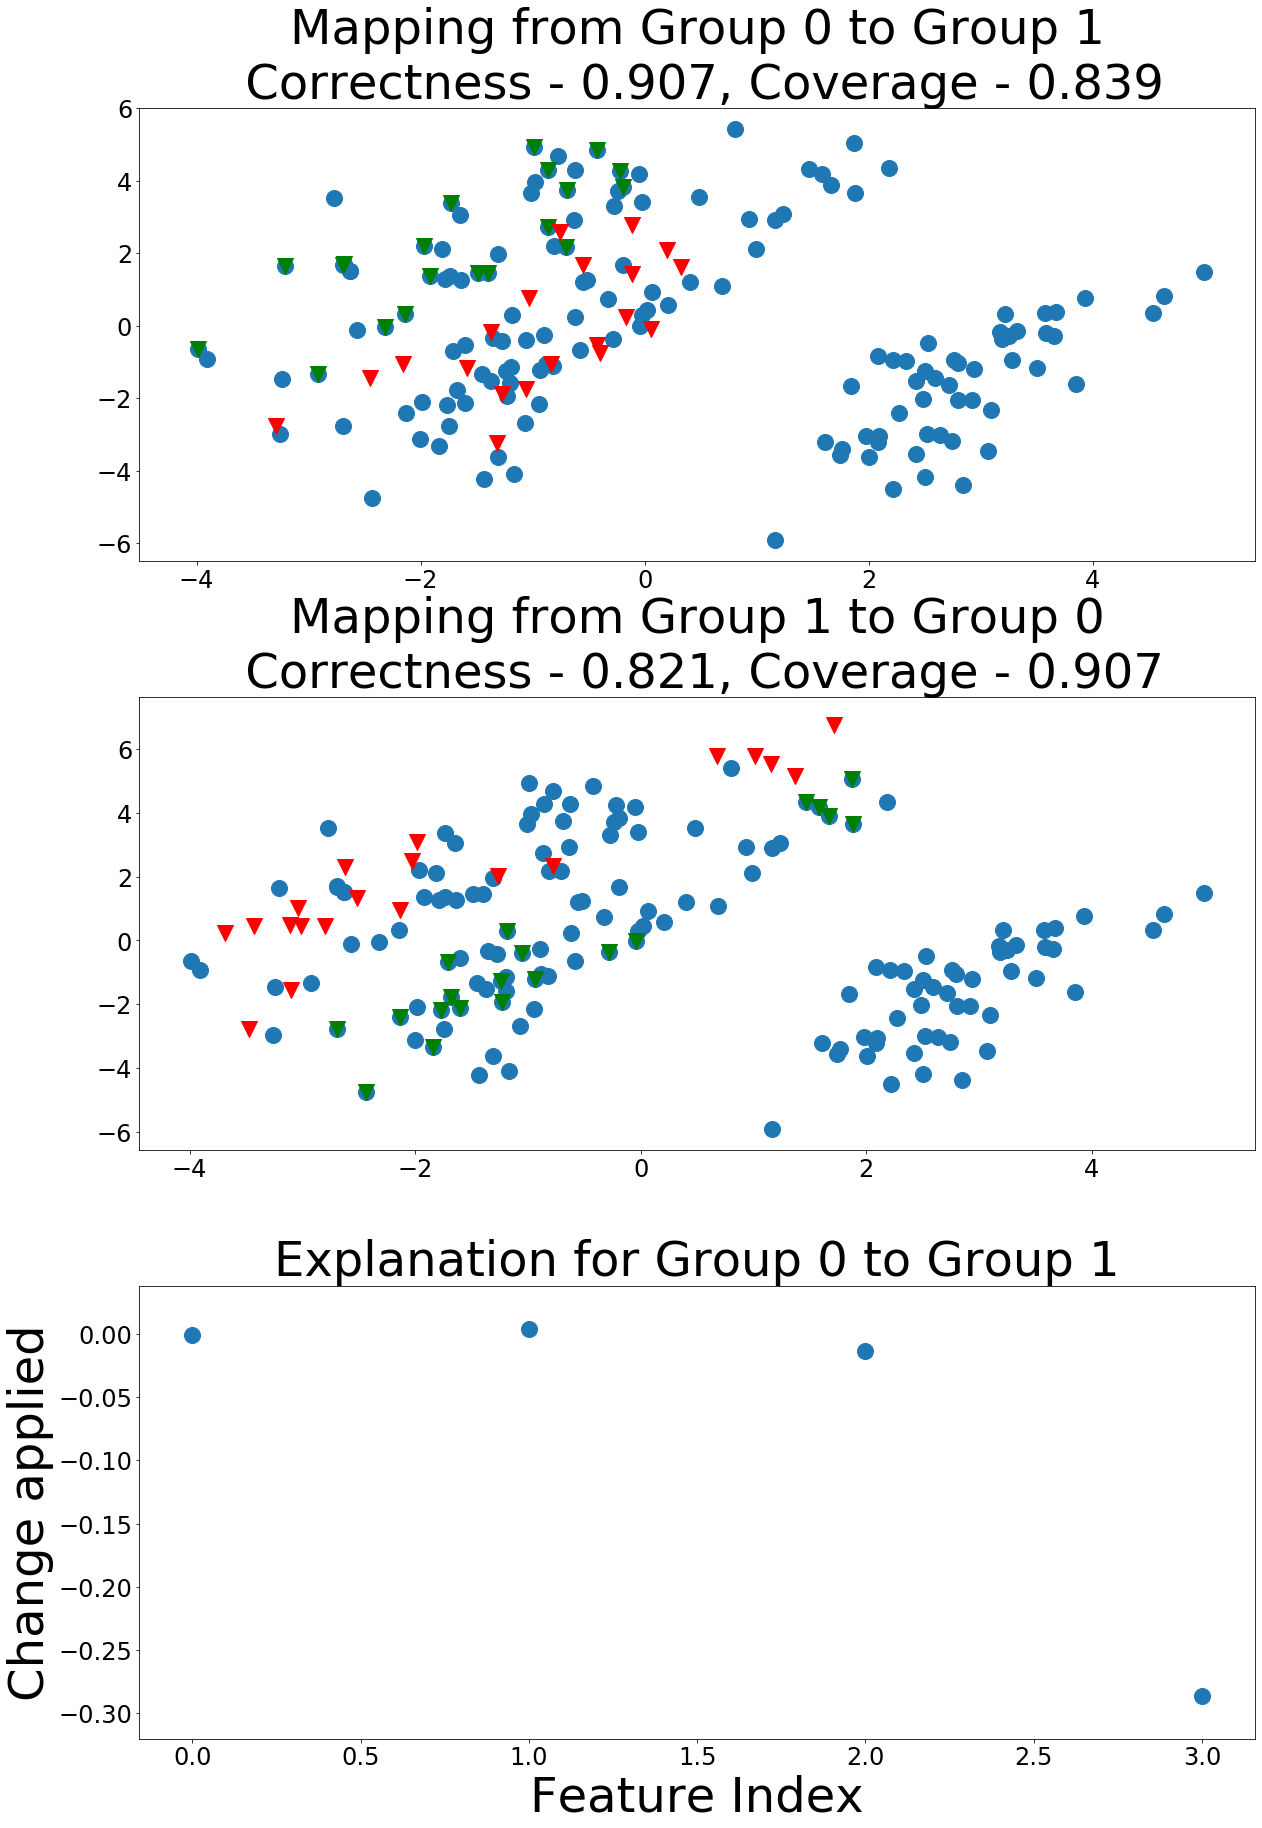

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


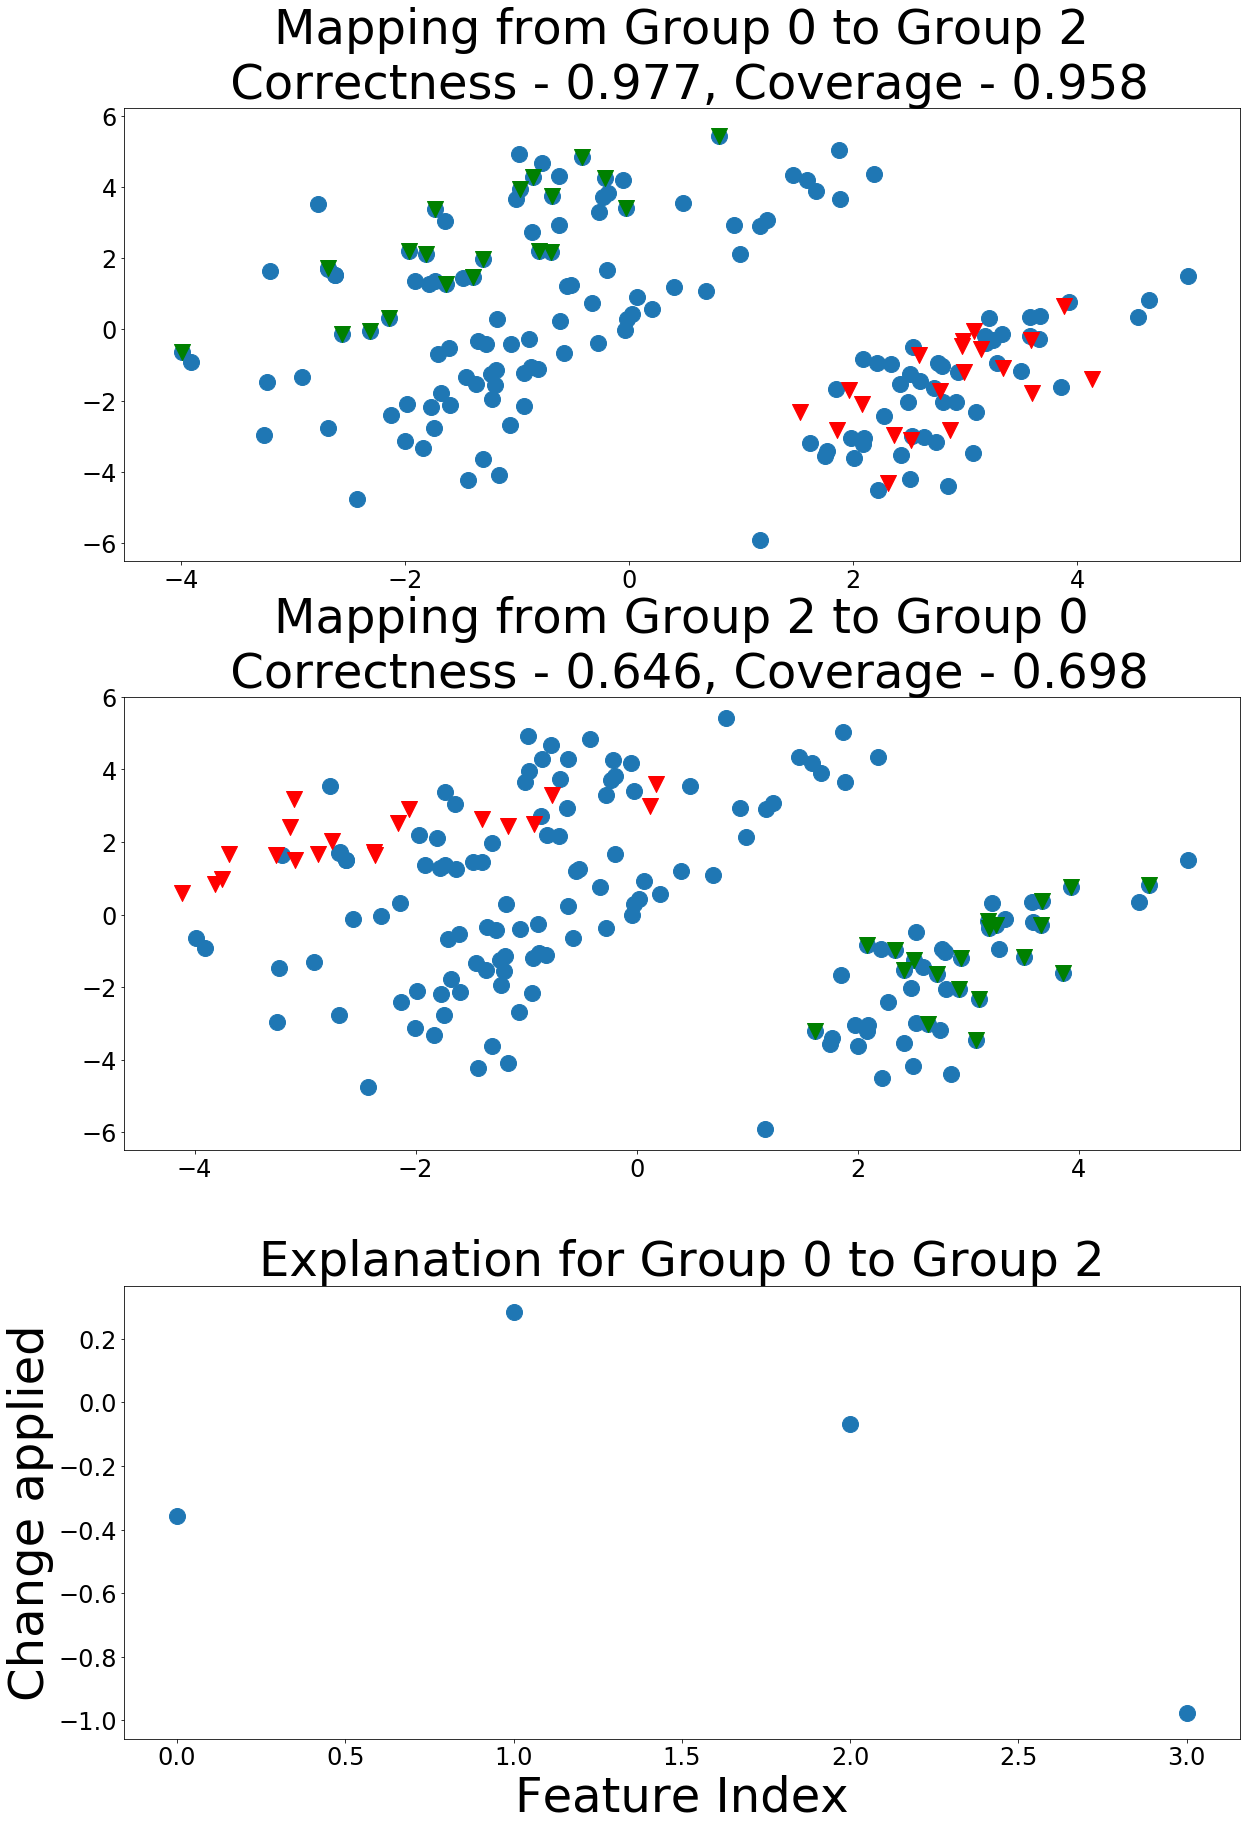

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


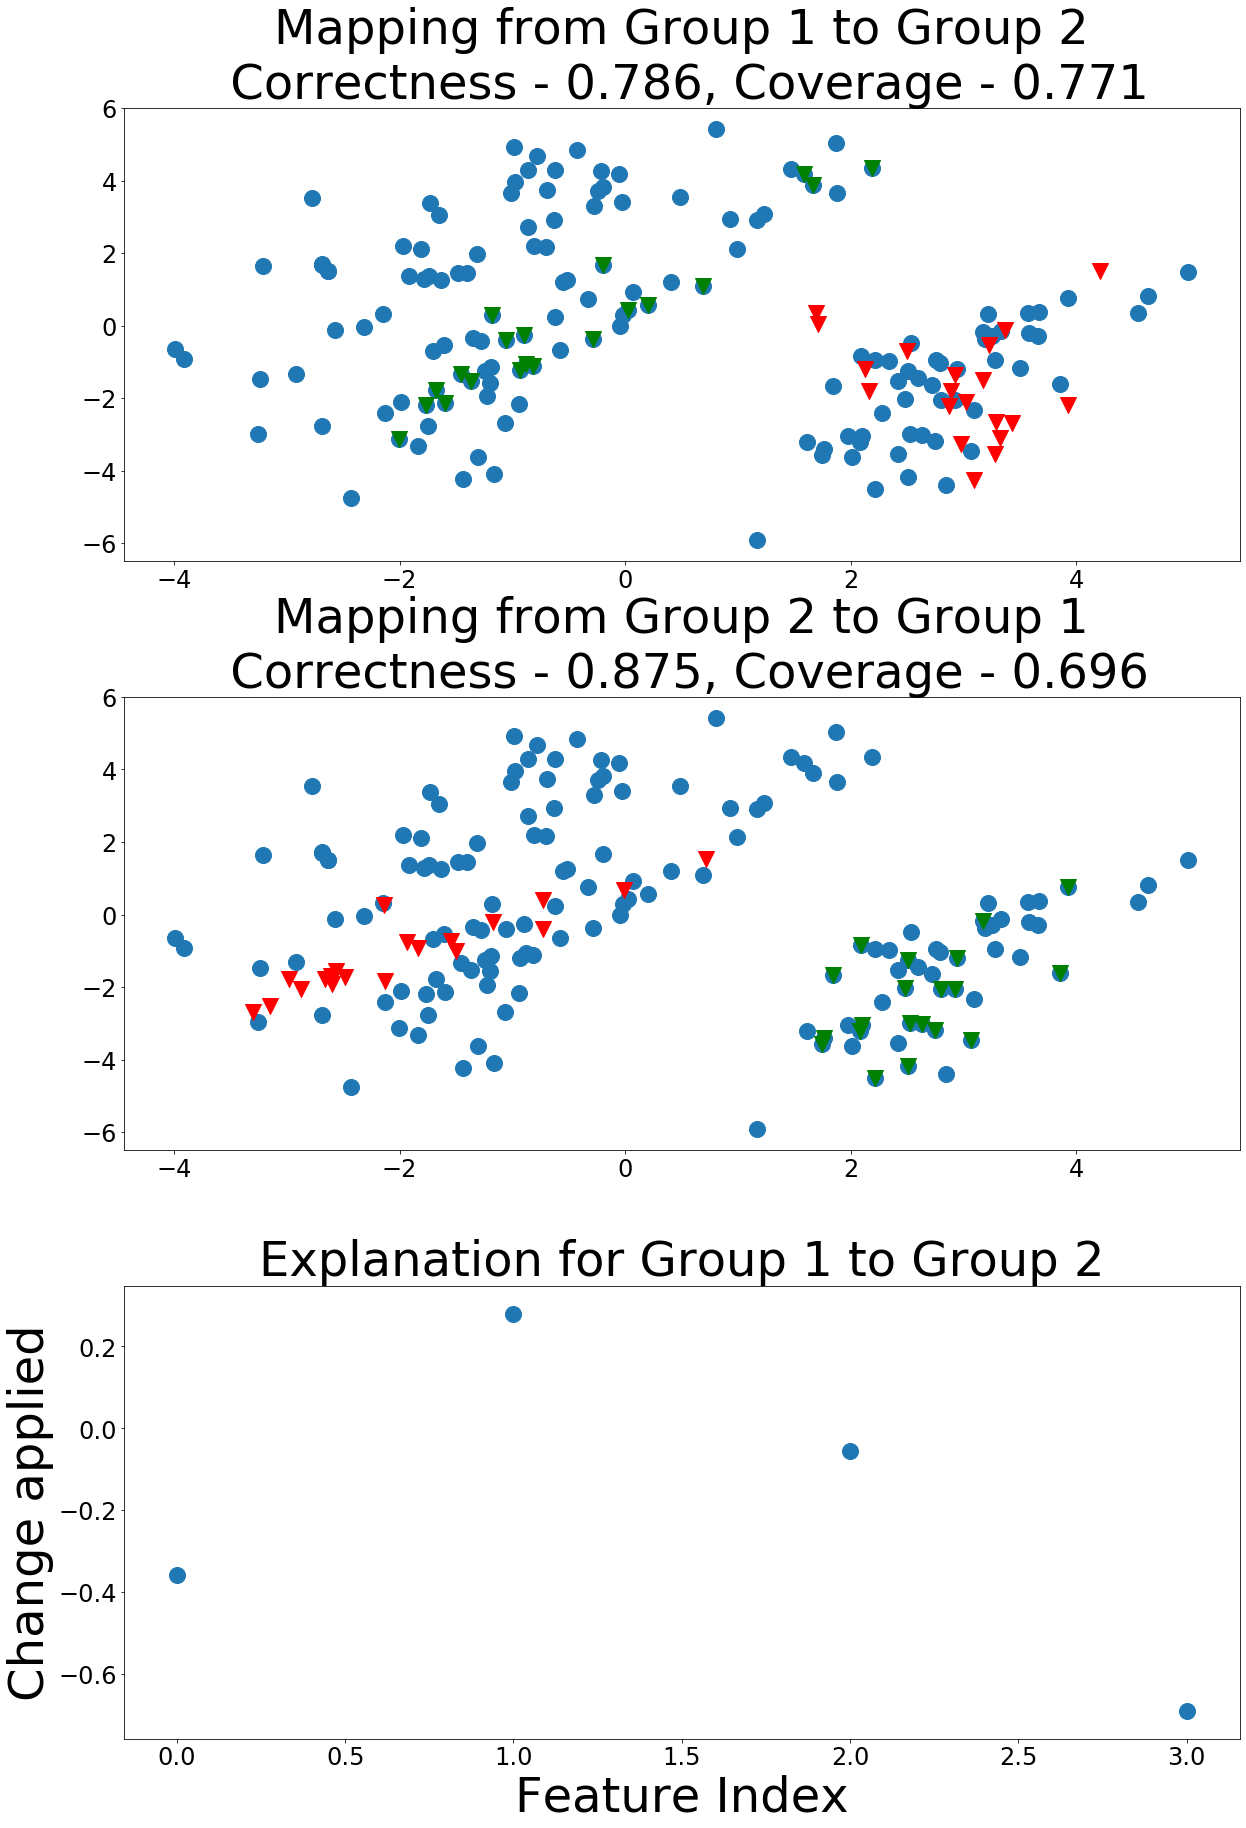

In [11]:
# Visualize the group explanations

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 0, 1, name = "iris-0to1.png", num_points = 20)

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 0, 2, name = "iris-0to2.png", num_points = 20)

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 1, 2, name = "iris-1to2.png", num_points = 20)


In [12]:
# Group 0 is Iris Virginica, Group 1 is Iris Versicolour, and Group 2 is Iris Setosa
# The main separating factor is feature 3 (petal width): 0 -> 2 has a large decrease while 0 -> 1 has a small increase
# That results is consistent with the decision tree from here:  https://sebastianraschka.com/Articles/2014_intro_supervised_learning.html

[-0.27231929  0.19237777 -0.24223139 -0.01898343 -0.26581688  0.10376928
 -0.16381517  0.03590061 -0.05708616 -0.13879905 -0.18619909  0.25270841
  0.1781687  -0.11163551  0.04339611 -0.2393142  -0.14874114  0.11865797
  0.02569529 -0.25366878  0.13704779 -0.021351   -0.11133921  0.18273687
 -0.05794131  0.08705239 -0.15066788 -0.04647966 -0.19411261  0.23435521
 -0.04107131  0.07354761  0.05405131  0.12392487  0.09919332 -0.10130483
  0.1327884   0.12839131 -0.06479025 -0.19414022 -0.02632735  0.24762923
  0.09865046]


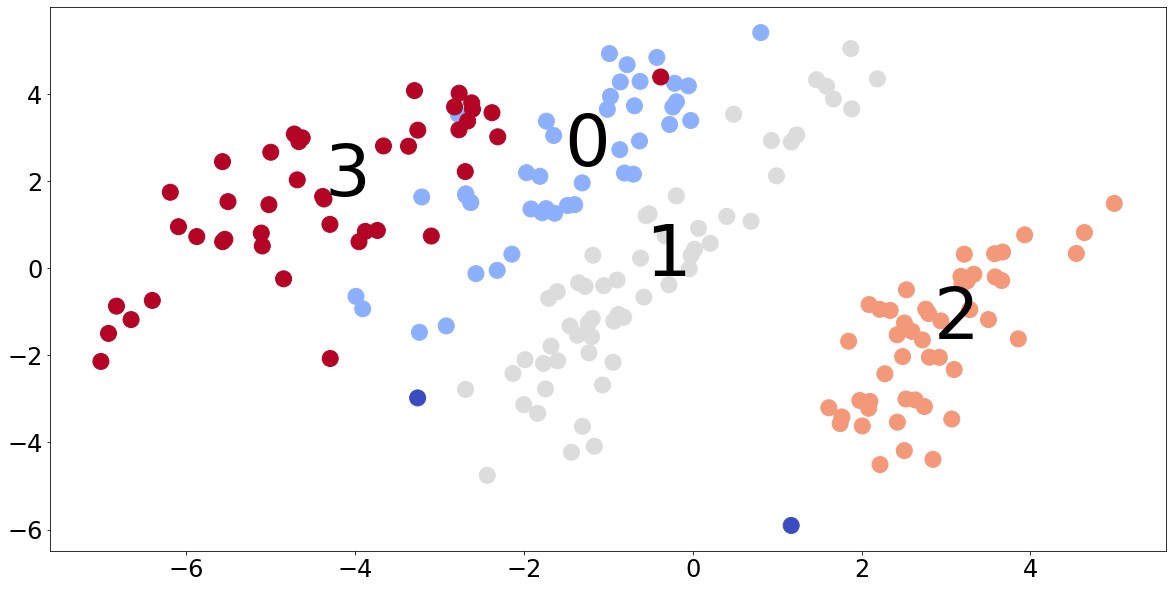

In [13]:
# Let's "corrupt" one of the groups

target_corrupted = 0

indices_corrupted = np.where(labels == target_corrupted)
n_corrupted = len(indices_corrupted[0])

x_corrupted = x[indices_corrupted]
x_corrupted[:, 1] -= 0.4 + np.random.uniform(low = -0.1, high = 0.1, size = n_corrupted)

print(x_corrupted[:, 1])

x_full = np.vstack((x, x_corrupted))

np.savetxt("Data/X_corrupted.tsv", x_full, delimiter = "\t")

labels_full = np.vstack((np.expand_dims(labels, 1), num_clusters * np.ones((n_corrupted,1))))

np.savetxt("Data/labels_corrupted.tsv", labels_full, delimiter = "\t")

# Compute the new representation
data_rep_full = sess.run(rep, feed_dict={X: x_full, D: np.zeros((1, input_dim))})

# Visualize the clusters in the learned representation
means_full, centers_full, indices_full = plot_groups(x_full, data_rep_full, num_clusters + 1, labels_full, name = "iris-rep-corrupted.png")



In [14]:
# Compute the group explanations

best_val = 0.0
for i in range(ntrials):
    deltas = explain(load_model, means_full, centers_full, learning_rate = 0.01, consecutive_steps = 5, lambda_global = lg)
    a, b = metrics(load_model, x_full, indices_full, deltas, epsilon)
    
    val = np.mean(a)
    
    if val > best_val:
        best_val = val
        np.save("deltas_corrupted.npy", deltas)
    
    os.system("rm -rf explanation")

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


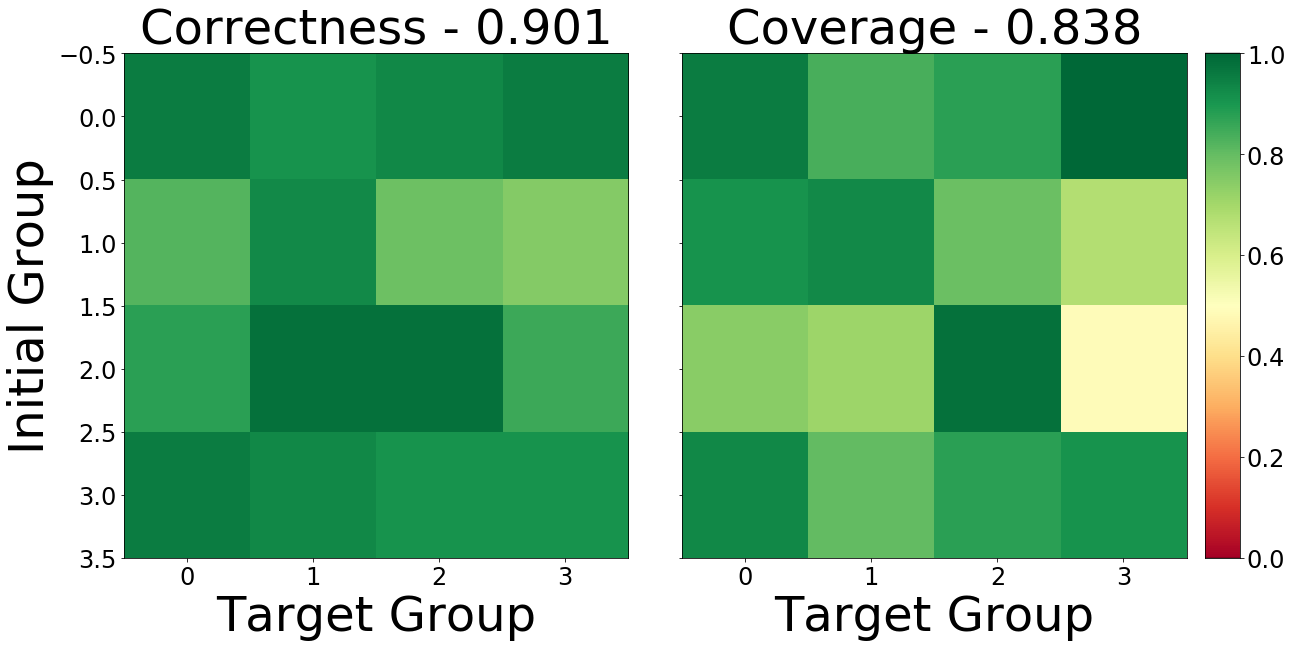

In [15]:
# Evaluate the explanations

deltas = np.load("deltas_corrupted.npy")

a, b = metrics(load_model, x_full, indices_full, deltas, epsilon)

plot_metrics(a, b, name = "iris-metrics-corrupted.png")

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


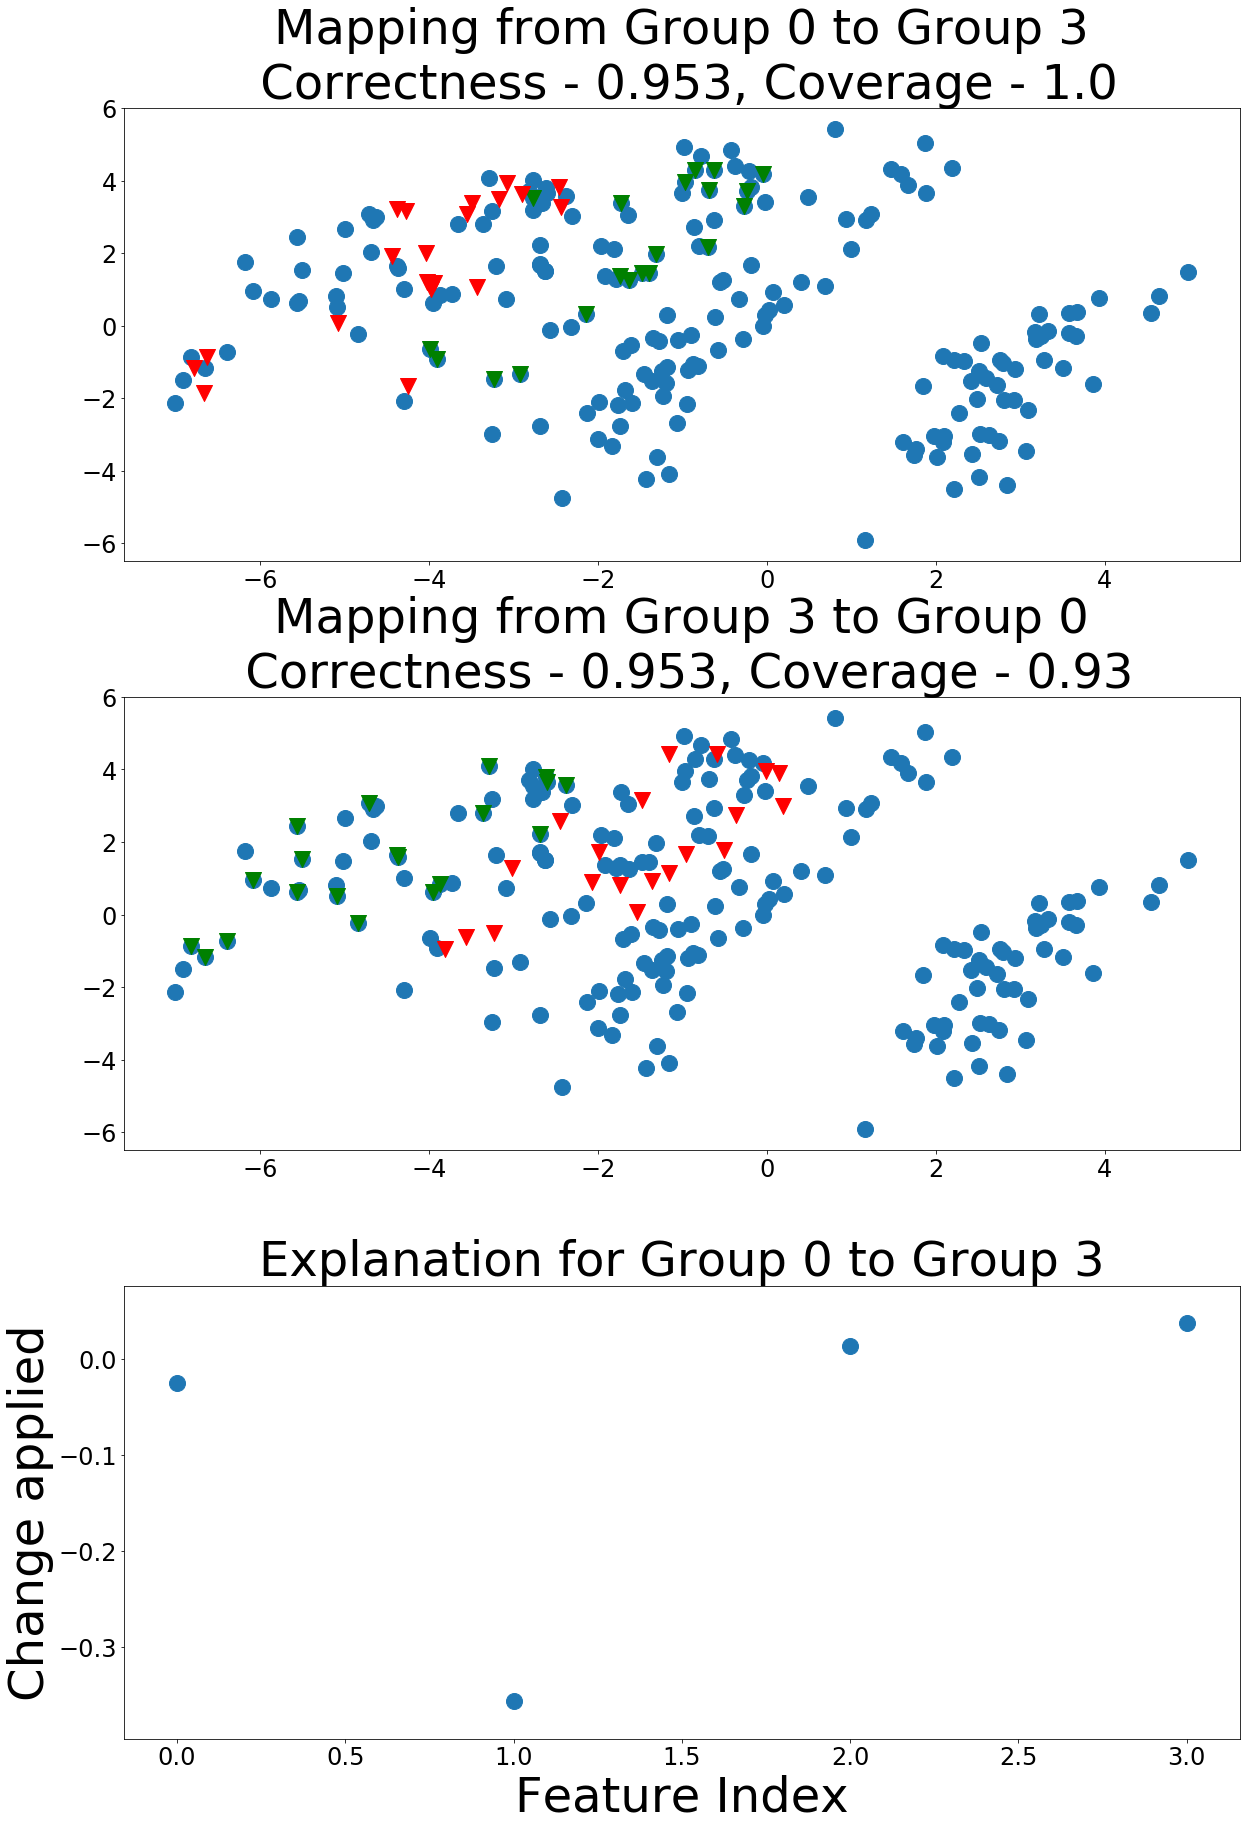

In [16]:
# Check if we found the corruption

plot_explanation(load_model, x_full, data_rep_full, indices_full, deltas, a, b, target_corrupted, num_clusters, name = "iris-t2c.png", num_points = 20)


[[-0.    0.   -0.01 -0.29]
 [-0.36  0.28 -0.07 -0.98]]
[[-0.    0.   -0.01 -0.29]
 [-0.38  0.17 -0.15 -0.91]]


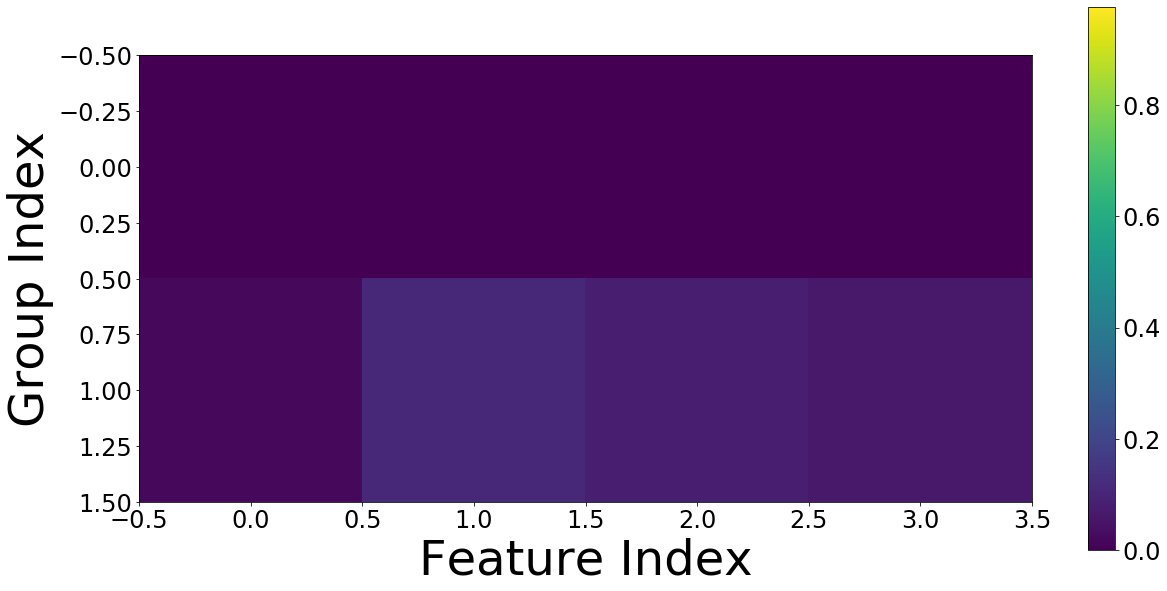

In [17]:
# Evaluate how much the other explanations changed

deltas_original = np.load("deltas.npy")

plot_similarity(deltas, deltas_original, "iris-corrupted-similarity.png")
